        E:\Data\FinalResults\Dsp\0845 - Starting Cell Cross Day Stability is already existed!


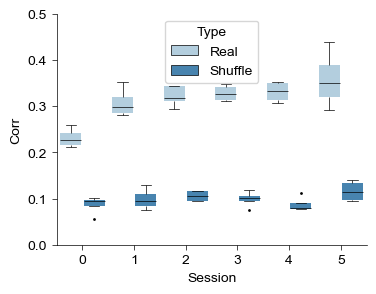

Compared with Shuffle:
TtestResult(statistic=13.023073074714649, pvalue=0.000977659950737782, df=3)
TtestResult(statistic=17.369704588707503, pvalue=0.0004158488750388401, df=3)
TtestResult(statistic=9.66701092058497, pvalue=0.002350238416161251, df=3)
TtestResult(statistic=13.153761786082166, pvalue=0.0009491998265930453, df=3)
TtestResult(statistic=23.878147417318146, pvalue=0.0001609657669097535, df=3)
TtestResult(statistic=11.530702398227872, pvalue=0.0014004500024771692, df=3)
Across Day
F_onewayResult(statistic=4.910960856451946, pvalue=0.005218204465471253)


In [10]:
from mylib.statistic_test import *

code_id = "0845 - Starting Cell Cross Day Stability"
loc = join(figpath, "Dsp", code_id)
mkdir(loc)

def calc_stability(mouse: int):
    traces = []
    for i in np.where(f2['MiceID'] == mouse)[0]:
        with open(f2['Trace File'][i], 'rb') as handle:
            trace = pickle.load(handle)
        traces.append(trace)

    with open(f_CellReg_dsp['cellreg_folder'][
        np.where(f_CellReg_dsp['MiceID'] == mouse)[0][0]
    ], 'rb') as handle:
        index_map = pickle.load(handle).astype(np.int64)
    
        if mouse != 10232:
            index_map = index_map[1:, :]
    
    mean_corr = np.zeros(6)
    mean_corr_shuf = np.zeros(6)
    D = GetDMatrices(1, 48)
    
    for i in tqdm(range(1, 7)):
        cell_idx = np.where(
            (index_map[i-1, :] != 0) &
            (index_map[i, :] != 0)
        )[0]
        
        cell_idx = cell_idx[np.where(
            (traces[i-1]['SC'][index_map[i-1, cell_idx]-1] == 1) |
            (traces[i]['SC'][index_map[i, cell_idx]-1] == 1)
        )[0]]
        
        shuf_cell = index_map[i, cell_idx][np.random.permutation(cell_idx.shape[0])]
        
        corr = np.zeros(cell_idx.shape[0])
        corr_shuf = np.zeros(cell_idx.shape[0])
        
        routes = [0, 1, 2, 3, 0, 0, 4, 5, 6, 0]
        for j in range(cell_idx.shape[0]):
            shared_routes = np.unique(np.concatenate([
                traces[i-1]['SC_EncodePath'][index_map[i-1, cell_idx[j]]-1],
                traces[i]['SC_EncodePath'][index_map[i, cell_idx[j]]-1],
            ])).astype(np.int64)
            
            corr_routes = []
            corr_routes_shuf = []
            for r in shared_routes:
                bins = np.concatenate([Father2SonGraph[i] for i in CP_DSP[routes[r]]])
                argsort = np.argsort(D[SP_DSP[routes[r]]-1, bins-1])[:16*5]
                sorted_bins = bins[argsort]
                corr_routes.append(
                    np.corrcoef(
                        traces[i-1][f"node {r}"]['smooth_map_all'][index_map[i-1, cell_idx[j]]-1, sorted_bins-1],
                        traces[i][f"node {r}"]['smooth_map_all'][index_map[i, cell_idx[j]]-1, sorted_bins-1]
                    )[0, 1]
                )
                corr_routes_shuf.append(
                    np.corrcoef(
                        traces[i-1][f"node {r}"]['smooth_map_all'][index_map[i-1, cell_idx[j]]-1, sorted_bins-1],
                        traces[i][f"node {r}"]['smooth_map_all'][shuf_cell[j]-1, sorted_bins-1]
                    )[0, 1]                    
                )
            
            corr[j] = np.nanmean(corr_routes)
            corr_shuf[j] = np.nanmean(corr_routes_shuf)
        
        mean_corr[i-1] = np.nanmean(corr)
        mean_corr_shuf[i-1] = np.nanmean(corr_shuf)
    
    del traces, index_map
    return mean_corr, mean_corr_shuf

if exists(join(figdata, f"{code_id}.pkl")) == False:
    Data = {
        "MiceID": [],
        "Session": [],
        "Corr": [],
        "Type": []
    }         
    
    for mouse in [10212, 10224, 10227, 10232]:
        mean_corr, mean_corr_shuf = calc_stability(mouse)
        
        Data['MiceID'].append(np.repeat(mouse, 12))
        Data['Session'].append(np.concatenate([np.arange(6)]*2))
        Data['Corr'].append(np.concatenate([mean_corr, mean_corr_shuf]))
        Data['Type'].append(np.repeat(["Real", "Shuffle"], 6))
        
    for k in Data.keys():
        Data[k] = np.concatenate(Data[k])
        
    print(Data['Corr'].shape)
    
    with open(join(figdata, f"{code_id}.pkl"), 'wb') as f:
        pickle.dump(Data, f)
    
    D = pd.DataFrame(Data)
    D.to_excel(join(figdata, f"{code_id}.xlsx"), index=False)
else:
    with open(join(figdata, f"{code_id}.pkl"), 'rb') as handle:
        Data = pickle.load(handle)

fig = plt.figure(figsize=(4, 3))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'],  ifxticks=True, ifyticks=True)
box = sns.boxplot(
    x="Session",
    y="Corr",
    data = Data,
    hue = "Type",
    palette='Blues',
    ax=ax,
    linecolor='k',
    linewidth=0.5,
    fliersize=1,
    width=0.9,
    gap=0.1
)
for b in box.patches:
    b.set_linewidth(0)

ax.set_ylim(0, 0.5)
ax.set_xlim(-0.5, 5.5)
plt.savefig(join(loc, "Stability.png"), dpi=600)
plt.savefig(join(loc, "Stability.svg"), dpi=600)
plt.show()

print("Compared with Shuffle:")
for s in range(6):
    idx0 = np.where((Data['Session'] == s)&(Data['Type'] == 'Real'))[0]
    idx1 = np.where((Data['Session'] == s)&(Data['Type'] == 'Shuffle'))[0]
    print(ttest_rel(Data['Corr'][idx0], Data['Corr'][idx1]))
    
print("Across Day")
print(f_oneway(*[Data['Corr'][np.where((Data['Session'] == s)&(Data['Type'] == 'Real'))[0]] for s in range(6)]))
